In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from itertools import product
import os
import h5py
from tqdm import tqdm

#few utils
from few.utils.utility import get_p_at_t, get_mismatch, get_overlap
#few trajectory
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
#few waveform
from few.waveform import FastKerrEccentricEquatorialFlux, GenerateEMRIWaveform
from few.utils.constants import YRSID_SI

from few.amplitude.romannet import RomanAmplitude
from few.utils.modeselector import ModeSelector
from few.utils.ylm import GetYlms

#sef imports
from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.utils import generate_PSD, padding, inner_product
from stableemrifisher.fisher.derivatives import derivative

#LISAanalysistools imports
from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5

from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

import few

use_gpu = False

if not use_gpu:
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    # Uncomment if you want to force CPU or GPU usage
    # Leave commented to let FEW automatically select the best available hardware
    #   - To force CPU usage:
    cfg_set.enable_backends("cpu")
    #   - To force GPU usage with CUDA 12.x
    #cfg_set.enable_backends("cuda12x", "cpu")
    #   - To force GPU usage with CUDA 11.x
    # cfg_set.enable_backends("cuda11x", "cpu")
    #
    cfg_set.set_log_level("info");
else:
    pass #let the backend decide for itself.b

startup


In [3]:
#fixed parameters
T_LISA = 1.0 #observation time, years
dt = 10.0 #sampling interval, seconds

M_mu_range = [(1.5e6, 15.0), (1e6,10.0), (0.5e6,5.0)] #MBH mass in solar masses
x0 = 1.0 #inclination, must be = 1.0 for equatorial model

# initial phases
Phi_phi0 = 0.0 #azimuthal phase
Phi_theta0 = 0.0 #polar phase
Phi_r0 = 0.0 #radial phase

# define the extrinsic parameters
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 4  # azimuthal viewing angle
qS = np.pi / 5  # polar sky angle
phiS = np.pi / 6  # azimuthal viewing angle
dist = 1.0  # distance in Gpc. We'll adjust this later to fix the SNR as 100.0

kerr_traj = EMRIInspiral(func=KerrEccEqFlux)

Output()

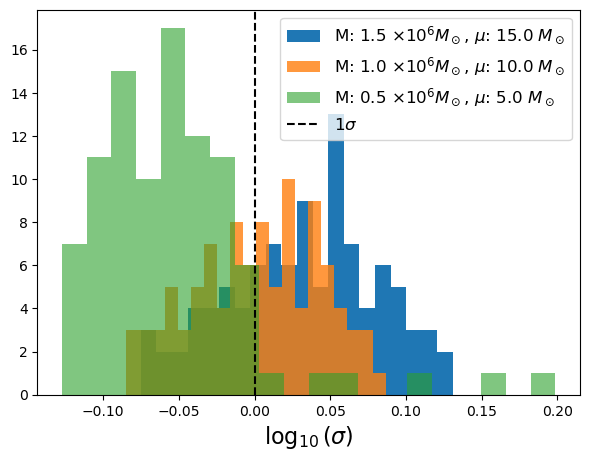

In [6]:
plt.figure(figsize=(7,5))

alphas = [1.0, 0.8, 0.6]

for j in range(len(M_mu_range)):
    M = M_mu_range[j][0]
    mu = M_mu_range[j][1]
    
    filename = f'Maha_ae_grid_Mtot_{M+mu}'
    if not os.path.exists(filename):
        os.mkdir(filename)
        
    filename_Fishers = 'Fishers'
    filename_Fishers = os.path.join(filename,filename_Fishers)
    
    calculate_Fishers = False #calculate Fishers using the full model
    calculate_derivatives = False #calculate derivatives using approximate models (for CV-bias calculation)

    with h5py.File(f"{filename}/data.h5", "r") as f:
        param_grid = f["gridpoints"][:]  # Read the dataset into a NumPy array
        p_range = f["p0"][:] + 0.5 #buffer
        dist_range = f["dists"][:]  # Read the dataset into a NumPy array

    alternate_model = "l2FastKerr"
    
    filename_bias = os.path.join(filename,alternate_model)

    sigma_contours = []
    for i in range(len(param_grid)):
        
        with h5py.File(f"{filename_bias}/biased_params_{i}.h5","r") as f:
            sigma_contours.append(np.array(f["sigma_contours"]))

    sigma_contours = np.array(sigma_contours)

    mask = np.log10(sigma_contours) < 0.2
    
    sigma_contours = sigma_contours[mask]
    
    sigma_contours = np.log10(np.array(sigma_contours))
    
    plt.hist(sigma_contours,bins=20, alpha=alphas[j], label=rf"M: {M/1e6} $\times 10^6 M_\odot$, $\mu$: {mu} $M_\odot$")

plt.axvline(np.log10(1),linestyle='--',color='k',label=r'$1\sigma$')
plt.legend(fontsize=12)
plt.xlabel(r"$\log_{10}(\sigma)$",fontsize=16)
plt.savefig("source_comparison_Mahalonobis.pdf",bbox_inches='tight',dpi=300)
plt.show()